In [55]:


import pickle

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import (
    GradientBoostingRegressor,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from src.score import ScoringTool
from src.adjustment import AdjustmentTool
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, accuracy_score, explained_variance_score, mean_absolute_percentage_error
from xgboost import XGBRegressor, XGBClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

In [205]:
mse = []
mape = []
score = []
for test_era in range(1003, 1033):

    dataframes = []
    for era in range(test_era - 3, test_era + 1):
        dataframes.append(pd.read_csv(f"../data_collection/data/processed_data/model_3_data_{era}.csv"))
    dataframe = pd.concat(dataframes)
    features = [
        "nominator",
        "validator",
        "proportional_bond",
        "total_bond",
        "overall_total_bond",
        "overall_proportional_bond",
        "era",
        "number_of_validators",
        "validator_frequency_current_era",
        "average_proportional_bond",
        "average_total_bond",
        "nominator_index",
        "validator_index",
        "nominator_centrality",
        "validator_centrality",
        "probability_of_selection",
        "expected_sum_stake",
    ]
    target = "solution_bond"
    X = dataframe.loc[:, features]
    y = dataframe.loc[:, target]
    drop_columns = X.select_dtypes(include=["object"]).columns
    X_train = X[X["era"] != test_era].drop(drop_columns, axis=1)
    X_train = X_train.drop(["era"], axis=1)

    X_test = X[X["era"] == test_era].drop(drop_columns, axis=1)
    X_test = X_test.drop(["era"], axis=1)

    y_train = y[X["era"] != test_era]
    y_test = y[X["era"] == test_era]

    transform_columns = X_train.select_dtypes(exclude=["object"]).columns
    column_transformer = make_column_transformer(
        (
            MinMaxScaler(),
            transform_columns,
        ),
        remainder="passthrough",
    )

    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)
    model = LGBMRegressor(
                random_state=42,
                cat_smooth=42,
                colsample_bytree=0.6,
                learning_rate=0.017729352667401443,
                max_depth=10,
                min_child_samples=11,
                n_estimators=979,
                num_leaves=253,
                reg_alpha=0.3815954846018609,
                reg_lambda=0.44273999607539605,
                subsample=0.6


            )


    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                           callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
                           )



    mse.append(mean_squared_error(y_test, model.predict(X_test), squared=False))
    mape.append(mean_absolute_percentage_error(y_test, model.predict(X_test)))
    score.append(model.score(X_test, y_test))

([<matplotlib.axis.XTick at 0x7f75bd304510>,
 [Text(0, 0, '1003'),
  Text(1, 0, '1004'),
  Text(2, 0, '1005'),
  Text(3, 0, '1006'),
  Text(4, 0, '1007'),
  Text(5, 0, '1008'),
  Text(6, 0, '1009'),
  Text(7, 0, '1010'),
  Text(8, 0, '1011'),
  Text(9, 0, '1012'),
  Text(10, 0, '1013'),
  Text(11, 0, '1014'),
  Text(12, 0, '1015'),
  Text(13, 0, '1016'),
  Text(14, 0, '1017'),
  Text(15, 0, '1018'),
  Text(16, 0, '1019'),
  Text(17, 0, '1020'),
  Text(18, 0, '1021'),
  Text(19, 0, '1022'),
  Text(20, 0, '1023'),
  Text(21, 0, '1024'),
  Text(22, 0, '1025'),
  Text(23, 0, '1026'),
  Text(24, 0, '1027'),
  Text(25, 0, '1028'),
  Text(26, 0, '1029'),
  Text(27, 0, '1030'),
  Text(28, 0, '1031'),
  Text(29, 0, '1032')])

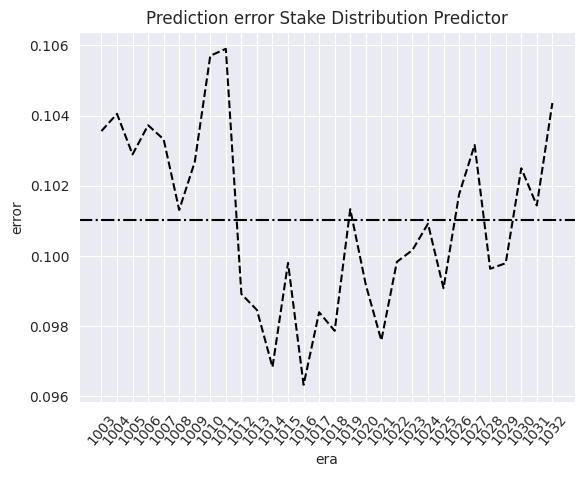

In [206]:
plt.plot(mse, color= "black", ls='--')
plt.ylabel('error')
plt.xlabel('era')
plt.axhline(np.mean(mse), c='black', ls='-.')
plt.title('Prediction error Stake Distribution Predictor')
plt.savefig("./images/prediction_error_model_3.png", bbox_inches='tight', dpi=300)
plt.xticks(range(30), range(1003,1033), rotation=50)

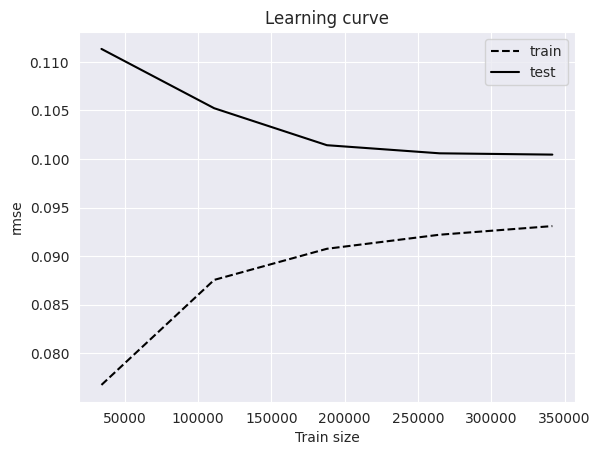

In [207]:
#plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
)
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
plt.plot(train_sizes, train_scores_mean, label="train", color="black", ls='--')
plt.plot(train_sizes, test_scores_mean, label="test", color="black", ls='-')

plt.legend()
plt.ylabel("rmse")
plt.xlabel("Train size")
plt.title("Learning curve")
plt.savefig("./images/learning_curve_model_3.png", bbox_inches='tight', dpi=300)
plt.show()

In [211]:
print(y.describe())

count    5.673740e+05
mean     1.547198e-01
std      1.955718e-01
min      1.000000e-09
25%      4.671567e-02
50%      9.108339e-02
75%      1.765497e-01
max      1.000000e+00
Name: solution_bond, dtype: float64


In [191]:
dataframes = []
test_era = 1003
for era in range(test_era - 3, test_era + 1):
    dataframes.append(pd.read_csv(f"../data_collection/data/processed_data/model_3_data_{era}.csv"))
dataframe = pd.concat(dataframes)
features = [
    "nominator",
    "validator",
    "proportional_bond",
    "total_bond",
    "overall_total_bond",
    "overall_proportional_bond",
    "era",
    "number_of_validators",
    "validator_frequency_current_era",
    "average_proportional_bond",
    "average_total_bond",
    "nominator_index",
    "validator_index",
    "nominator_centrality",
    "validator_centrality",
    "probability_of_selection",
    "expected_sum_stake",
]
target = "solution_bond"
X = dataframe.loc[:, features]
y = dataframe.loc[:, target]
drop_columns = X.select_dtypes(include=["object"]).columns
X_train = X[X["era"] != test_era].drop(drop_columns, axis=1)
X_train = X_train.drop(["era"], axis=1)

X_test = X[X["era"] == test_era].drop(drop_columns, axis=1)
X_test = X_test.drop(["era"], axis=1)

y_train = y[X["era"] != test_era]
y_test = y[X["era"] == test_era]

transform_columns = X_train.select_dtypes(exclude=["object"]).columns
column_transformer = make_column_transformer(
    (
        MinMaxScaler(),
        transform_columns,
    ),
    remainder="passthrough",
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

#plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
)

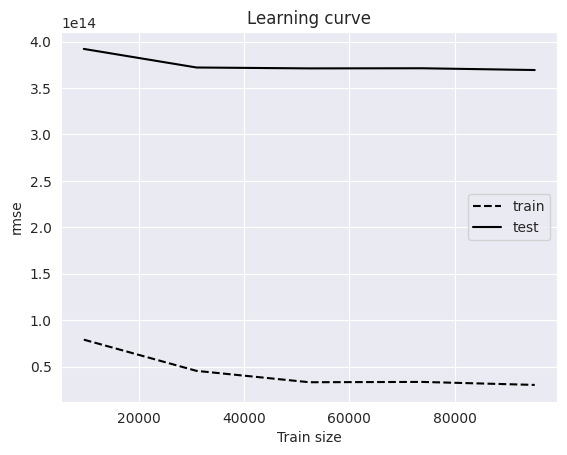

In [200]:

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
plt.plot(train_sizes, train_scores_mean, label="train", color="black", ls='--')
plt.plot(train_sizes, test_scores_mean, label="test", color="black", ls='-')

plt.legend()
plt.ylabel("rmse")
plt.xlabel("Train size")
plt.title("Learning curve")
plt.savefig("./images/learning_curve_model_3_v2.png", bbox_inches='tight', dpi=300)
plt.show()

In [5]:
import json

In [142]:
era=1003
with open(f"../models/results/lgbm_model_3_{era}_log_adj4.json", "r") as f:
    results = json.load(f)
    score_prediction_vectorized = results["score_prediction"]
    score_solution = results["score_stored"]
with open(f"../models/results/lgbm_model_3_{era}_log_sequentialadj.json", "r") as f:
    results_seq = json.load(f)
    score_prediction_sequential = results_seq["score_prediction"]


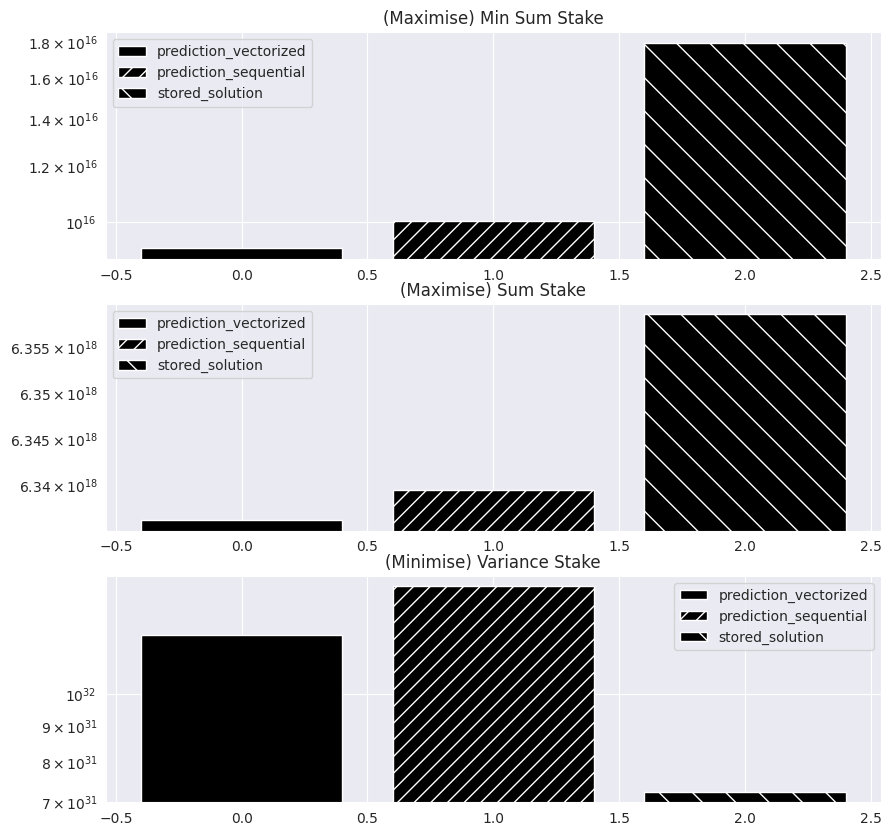

In [143]:
#plot each of the three columns to compare in one subplot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].bar(0,score_prediction_vectorized[0], label="prediction_vectorized", color="black")
axs[0].bar(1,score_prediction_sequential[0], label="prediction_sequential", color="black", hatch='//')
axs[0].bar(2, score_solution[0], label="stored_solution", color="black", hatch='\\')
axs[0].set_yscale('log')
axs[0].set_title("(Maximise) Min Sum Stake")
axs[0].legend()
axs[1].bar(0,score_prediction_vectorized[1], label="prediction_vectorized", color="black")
axs[1].bar(1,score_prediction_sequential[1], label="prediction_sequential", color="black", hatch='//')
axs[1].bar(2,score_solution[1], label="stored_solution", color="black", hatch='\\')
axs[1].set_yscale('log')
axs[1].set_title("(Maximise) Sum Stake")
axs[1].legend()
axs[2].bar(0,score_prediction_vectorized[2], label="prediction_vectorized", color="black")
axs[2].bar(1,score_prediction_sequential[2], label="prediction_sequential", color="black", hatch='//')
axs[2].bar(2,score_solution[2], label="stored_solution", color="black", hatch='\\')
axs[2].set_yscale('log')
axs[2].set_title("(Minimise) Variance Stake")
axs[2].legend()
plt.savefig("./images/score_comparison_model_3.png", bbox_inches='tight', dpi=300)
plt.show()



In [144]:
min_sum_win = {}
sum_win = {}
var_win = {}
for era in range(1000,1001):
    """
    #with open(f"../models/results/lgbm_model_3_{era}_log_adj4.json", "r") as f:
        results = json.load(f)
        score_prediction_vectorized = results["score_prediction"]
        print(f"{era}: {score_prediction_vectorized}")
        score_solution = results["score_stored"]
        print(f"{era}: {score_solution}")"""

    df = pd.read_csv(f"../data_collection/data/intermediate_results/{era}_model_2_predictions.csv")

    with open(f"../models/results/lgbm_model_3_{era}_log_sequentialadj.json", "r") as f:
        results_seq = json.load(f)
        score_prediction_sequential = results_seq["score_prediction"]
        print(f"{era}: {score_prediction_sequential}")
        score_solution = results["score_stored"]
        print(f"{era}: {score_solution}")
    df['expected_sum'] = (df['prediction'] / df['prediction'].sum())
    if score_prediction_vectorized[0] > score_solution[0] or score_prediction_sequential[0] > score_solution[0]:
        min_sum_win[era] = 1
    if score_prediction_vectorized[1]  > score_solution[1] or score_prediction_sequential[1] > score_solution[1]:
        sum_win[era] = 1
    if score_prediction_vectorized[2]  < score_solution[2] or score_prediction_sequential[2] < score_solution[2]:
        var_win[era] = 1


1000: [12658254784093443, 6329024167115547724, 218227860212902795902789521244160]
1000: [17992528428950926, 6358620700067775622, 72412072534289632287033542049792]


In [145]:
print(np.min(df['expected_sum'])*score_prediction_sequential[1])


1.505212356930345e+16


In [146]:
min_sum_win

{}

In [147]:
len(sum_win)

0

In [148]:
var_win

{}